In [2]:
import pandas as pd


file_list = [
    
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_1_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_2_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_3_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_4_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_5_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_6_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_7_7.csv'
]

# 从CSV文件读取数据，并将日期列转换为datetime类型
df_list = [pd.read_csv(f, parse_dates=["IncorporationDate"]) for f in file_list]

# 合并所有数据框为一个大的数据框
df = pd.concat(df_list, ignore_index=True)
df.dropna(subset=['lat', 'long'], inplace=True)

In [3]:
def filter_by_postcode_prefix(df, prefix):
    # Split the postcode at the space to get the prefix
    df['PostCodePrefix'] = df['RegAddress.PostCode'].str.split().str[0]
    # Filter the DataFrame based on the prefix
    df_filtered = df[df['PostCodePrefix'].str.startswith(prefix)]
    return df_filtered

df_filtered = filter_by_postcode_prefix(df, 'CF14')
df_filtered.head()

,CompanyName,RegAddress.PostCode,lat,long,CompanyCategory,IncorporationDate,SICCode.SicText_1,PostCodePrefix
299,&SPACE LTD,CF14 0XQ,51.534693,-3.179534,Private Limited Company,2022-04-11,62090 - Other information technology service a...,CF14
418,'SGWENNU LIMITED,CF14 6DH,51.518695,-3.211434,Private Limited Company,2015-04-21,90020 - Support activities to performing arts,CF14
440,'WEDDINGBOOKER.COM' LIMITED,CF14 3AY,51.501567,-3.203555,Private Limited Company,2018-04-24,90030 - Artistic creation,CF14
635,. LTD,CF14 8LH,51.522153,-3.194287,Private Limited Company,2018-04-12,63990 - Other information service activities n...,CF14
698,0'BRIEN'S MAINTENANCE LIMITED,CF14 4ST,51.523159,-3.204966,Private Limited Company,2022-07-04,41201 - Construction of commercial buildings,CF14


In [4]:
import numpy as np

#df_filtered['Date'] = df_filtered['IncorporationDate'].dt.to_period('D')
df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


##df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().reset_index(name='CompanyCount')
##print(df_filtered_count.head(50))

df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).agg({
    'CompanyName': lambda x: list(x),
    'lat': 'first',
    'long': 'first',
    'SICCode.SicText_1': lambda x: list(x),
}).reset_index()

# df_filtered_count['CompanyCount'] = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().values

df_filtered_count.head()


/var/folders/00/r2pslk7j4k158048921m90wm0000gn/T/ipykernel_2574/2322913796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


,RegAddress.PostCode,Date,CompanyName,lat,long,SICCode.SicText_1
0,CF14 0AB,2021-02-10,[BIFFY LTD],51.535540,-3.159611,[47910 - Retail sale via mail order houses or ...
1,CF14 0AD,2021-08-31,[MOORLYNCH LIMITED],51.545674,-3.166878,[98000 - Residents property management]
2,CF14 0AD,2022-08-26,[ST DENYS LIMITED],51.545674,-3.166878,[98000 - Residents property management]
3,CF14 0AF,1999-09-10,[ICHABOD'S INDUSTRIES LIMITED],51.536125,-3.159612,[69201 - Accounting and auditing activities]
4,CF14 0AF,2017-08-29,[SUPPLY CHAIN ASSOCIATES LIMITED],51.536125,-3.159612,"[74909 - Other professional, scientific and te..."


In [ ]:
# df_filtered_count.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_filtered_count.csv', index=False)

In [ ]:
'''
import math
import ast

def calculate_density_score(df):
    # Convert 'CompanyName' column to list
    df['CompanyName'] = df['CompanyName'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Calculate total number of companies in each postcode
    company_counts = df.explode('CompanyName')['RegAddress.PostCode'].value_counts()

    # Find the postcode with the maximum number of companies
    max_companies = company_counts.max()

    # Calculate average number of companies per postcode (excluding the companies in the postcode with the maximum number of companies)
    avg_companies_per_postcode = math.ceil((company_counts.sum() - max_companies) / len(company_counts))

    # Calculate density score
    df['num_companies'] = df['RegAddress.PostCode'].map(company_counts)
    df['density_score'] = df['num_companies'].apply(
        lambda x: 0 if x <= avg_companies_per_postcode else ((x // avg_companies_per_postcode) - 0.5)
    )

    return df

df_test_2_1 = calculate_density_score(df_filtered_count)
df_test_2_1.head()

df_CF14_8LH_v5 = df_test_2_1[df_test_2_1['RegAddress.PostCode'] == 'CF14 0LX']
df_CF14_8LH_v5

'''

In [5]:
def calculate_density_scores(df):
    
    # Create a window column based on the date for half-year grouping
    df['Date'] = pd.to_datetime(df['Date'])
    df['Window'] = df['Date'].apply(lambda x: f"{x.year}-H1" if x.month <= 6 else f"{x.year}-H2")

    # Group by the window and postcode to get the number of companies for each postcode in each window
    df_grouped = df.groupby(['Window', 'RegAddress.PostCode']).size().reset_index(name='CompaniesCount')

    # Calculate the average number of companies for each window and merge it with the grouped dataframe
    avg_counts = df_grouped.groupby('Window')['CompaniesCount'].mean().reset_index()
    avg_counts.columns = ['Window', 'CompaniesCount_avg']
    df_grouped = df_grouped.merge(avg_counts, on='Window', how='left')

    # Calculate the difference from the average for each postcode in each window
    df_grouped['CompaniesCount_avg'] = np.ceil(df_grouped['CompaniesCount_avg'])
    df_grouped['Difference_from_Avg'] = df_grouped['CompaniesCount'] - df_grouped['CompaniesCount_avg']
    
    # Identify the postcodes with anomalous company counts for each window
    anomalies = df_grouped[df_grouped['Difference_from_Avg'] > df_grouped['CompaniesCount_avg']]

    # Calculate the cumulative scores for each postcode
    cumulative_scores = anomalies.groupby('RegAddress.PostCode').size() * 0.5
    cumulative_scores_df = cumulative_scores.reset_index()
    cumulative_scores_df.columns = ['RegAddress.PostCode', 'density_score']

    # Merge the cumulative scores with the original dataset
    df_final = df.merge(cumulative_scores_df, on='RegAddress.PostCode', how='left')

    # Fill NaN scores with 0
    df_final['density_score'] = df_final['density_score'].fillna(0)
    
    return df_final


In [ ]:
# output_df.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/output_df.csv', index=False)

In [6]:
# Re-define the modified function
def calculate_frequency_scores(df, n=2):

    # Sort dataframe by postcode and date
    df = df.sort_values(by=['RegAddress.PostCode', 'Date'])
    
    # Calculate the difference in days between two consecutive rows for each postcode
    df['Time_Diff'] = df.groupby('RegAddress.PostCode')['Date'].diff().dt.days

    # Get the minimum time difference for each postcode
    min_time_diffs = df.groupby('RegAddress.PostCode')['Time_Diff'].min().reset_index()
    
    # Handle postcodes with only one company (hence NaN in Time_Diff)
    single_company_postcodes = min_time_diffs[min_time_diffs['Time_Diff'].isna()]['RegAddress.PostCode'].tolist()
    df.loc[df['RegAddress.PostCode'].isin(single_company_postcodes), 'Time_Diff'] = np.inf
    min_time_diffs.loc[min_time_diffs['RegAddress.PostCode'].isin(single_company_postcodes), 'Time_Diff'] = np.inf
    
    # Sort by minimum time difference and assign ranks
    min_time_diffs = min_time_diffs.sort_values(by='Time_Diff')
    min_time_diffs['Rank'] = range(1, len(min_time_diffs) + 1)
    
    # Calculate the maximum rank for the exponential scoring function
    max_rank = len(min_time_diffs)
    
    # Define the exponential scoring function
    def exponential_score(rank, max_rank, n=2):
        return 5 * ((max_rank - rank + 1) / max_rank) ** n
    
    # Apply the exponential score formula
    min_time_diffs['frequency_Score'] = min_time_diffs['Rank'].apply(lambda x: round(exponential_score(x, max_rank, n=n), 1))
    
    # Assign a fixed frequency_Score for postcodes with only one company
    min_time_diffs.loc[min_time_diffs['Time_Diff'] == np.inf, 'frequency_Score'] = 0.0  # Assigning a fixed value
    
    # Merge the scores back to the original dataframe
    df = df.merge(min_time_diffs[['RegAddress.PostCode', 'frequency_Score']], on='RegAddress.PostCode', how='left')
    df = df.drop(columns=['Time_Diff'])  # Drop the Time_Diff column
    
    return df



In [7]:
# Combine both scoring methods and then aggregate for the final result
def compute_combined_scores(df):
    # Get the scores from both methods
    df_cumulative_scores = calculate_density_scores(df)
    df_postcode_scores = calculate_frequency_scores(df)
    
    # Combine both scores
    df['density_score'] = df_cumulative_scores['density_score']
    df['frequency_Score'] = df_postcode_scores['frequency_Score']
    
    # Calculate the total score
    df['Total_Score'] = df['density_score'] + df['frequency_Score']
    
    return df

# Compute the combined scores
df_dynamic_scores = compute_combined_scores(df_filtered_count)


In [ ]:
df_dynamic_scores.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_dynamic_scores.csv', index=False)

In [8]:
# Group by postcode to get the total score for each postcode
dynamic_scores_output = df_dynamic_scores.groupby(['RegAddress.PostCode', 'lat', 'long']).agg({
    'CompanyName': 'size',
    'Total_Score': 'first'
}).reset_index()

dynamic_scores_output.rename(columns={'CompanyName': 'CompanyCount'}, inplace=True)
dynamic_scores_output.head(10)


,RegAddress.PostCode,lat,long,CompanyCount,Total_Score
0,CF14 0AB,51.535540,-3.159611,1,0.0
1,CF14 0AD,51.545674,-3.166878,2,2.5
2,CF14 0AF,51.536125,-3.159612,2,0.7
3,CF14 0AH,51.536829,-3.170213,2,0.9
4,CF14 0AN,51.538160,-3.164782,1,0.0
5,CF14 0AY,51.543626,-3.180977,1,0.0
6,CF14 0BD,51.544607,-3.182617,4,1.5
7,CF14 0BE,51.545351,-3.182839,4,1.0
8,CF14 0BG,51.534132,-3.177338,2,1.1
9,CF14 0EP,51.545926,-3.182940,1,0.0


In [ ]:
# dynamic_scores_output.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/dynamic_scores_output.csv', index=False)

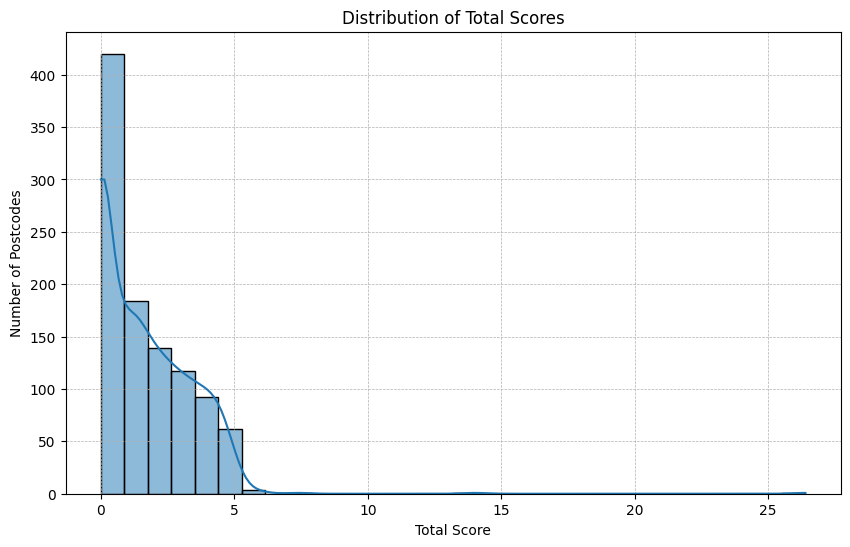

count    1021.000000
mean        1.631538
std         1.793027
min         0.000000
25%         0.000000
50%         1.300000
75%         2.800000
max        26.400000
Name: Total_Score, dtype: float64

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistical description of Total_Score
score_description = dynamic_scores_output["Total_Score"].describe()

# Plot the histogram for Total_Score
plt.figure(figsize=(10,6))
sns.histplot(dynamic_scores_output["Total_Score"], kde=True, bins=30)
plt.title("Distribution of Total Scores")
plt.xlabel("Total Score")
plt.ylabel("Number of Postcodes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

score_description


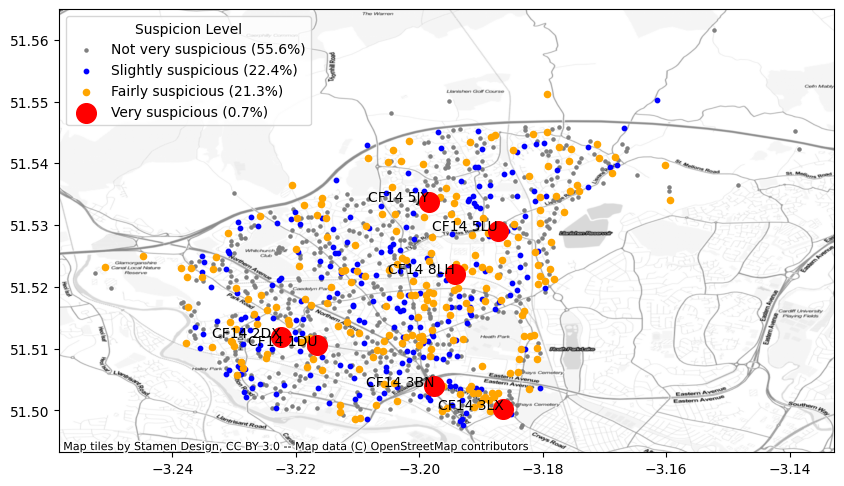

In [17]:
import contextily as ctx
import pandas as pd
import matplotlib.pyplot as plt

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define the color and size mapping based on the quantiles of 'SumScores'
def map_color_size(score):
    threshold_1 = 1.5
    threshold_2 = 3
    threshold_3 = 5

    if score <= threshold_1:
        return 'gray', 5, 'Not very suspicious'
    elif score <= threshold_2:
        return 'blue', 10, 'Slightly suspicious'
    elif score <= threshold_3:
        return 'orange', 20, 'Fairly suspicious'
    else:
        return 'red', 200, 'Very suspicious'

dynamic_scores_output['color'], dynamic_scores_output['size'], dynamic_scores_output['label'] = zip(*dynamic_scores_output['Total_Score'].apply(map_color_size))

# Calculate the total number of postcodes
total_postcodes = len(dynamic_scores_output)

# Define a dictionary for labels, colors, and sizes
label_dict = {
    'Not very suspicious': {'color': 'gray', 'size': 5},
    'Slightly suspicious': {'color': 'blue', 'size': 10},
    'Fairly suspicious': {'color': 'orange', 'size': 20},
    'Very suspicious': {'color': 'red', 'size': 200}
}

# Scatter plot
for label, attr in label_dict.items():
    idx = dynamic_scores_output['label'] == label
    postcode_count = len(dynamic_scores_output.loc[idx])
    percentage = postcode_count / total_postcodes * 100
    ax.scatter(dynamic_scores_output.loc[idx, 'long'], dynamic_scores_output.loc[idx, 'lat'], c=attr['color'], s=attr['size'], label=f'{label} ({percentage:.1f}%)')


    # If the label is "Very suspicious" (which corresponds to red), add the postal code text
    if label == "Very suspicious":
        for x, y, postcode in zip(dynamic_scores_output.loc[idx, 'long'], dynamic_scores_output.loc[idx, 'lat'], dynamic_scores_output.loc[idx, 'RegAddress.PostCode']):
            ax.text(x, y, postcode, ha='right', fontsize=10, color='black')

# Add legend
ax.legend(title="Suspicion Level")

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()


In [ ]:
def calculate_frequency_scores(df, n=2):
    # Load the dataframe
    
    # Convert date to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort dataframe by postcode and date
    df = df.sort_values(by=['RegAddress.PostCode', 'Date'])
    
    # Calculate the difference in days between two consecutive rows for each postcode
    df['Time_Diff'] = df.groupby('RegAddress.PostCode')['Date'].diff().dt.days
    
    # Get the minimum time difference for each postcode
    min_time_diffs = df.groupby('RegAddress.PostCode')['Time_Diff'].min().reset_index()
    
    # Handle postcodes with only one company (hence NaN in Time_Diff)
    single_company_postcodes = min_time_diffs[min_time_diffs['Time_Diff'].isna()]['RegAddress.PostCode'].tolist()
    df.loc[df['RegAddress.PostCode'].isin(single_company_postcodes), 'Time_Diff'] = np.inf
    
    # Re-calculate the minimum time difference for each postcode
    min_time_diffs = df.groupby('RegAddress.PostCode')['Time_Diff'].min().reset_index()
    
    # Sort by minimum time difference and assign ranks
    min_time_diffs = min_time_diffs.sort_values(by='Time_Diff')
    min_time_diffs['Rank'] = range(1, len(min_time_diffs) + 1)
    
    # Calculate the maximum rank for the exponential scoring function
    max_rank = len(min_time_diffs)
    
    # Define the exponential scoring function
    def exponential_score(rank, max_rank, n=2):
        return 5 * ((max_rank - rank + 1) / max_rank) ** n
    
    # Apply the exponential score formula
    min_time_diffs['frequency_Score'] = min_time_diffs['Rank'].apply(lambda x: round(exponential_score(x, max_rank, n=n), 1))
    
    # Merge the scores back to the original dataframe
    df = df.merge(min_time_diffs[['RegAddress.PostCode', 'frequency_Score']], on='RegAddress.PostCode', how='left')
    df = df.drop(columns=['Time_Diff'])  # Drop the Time_Diff column
    
    return df


In [11]:
import pandas as pd
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

df_hdbscan_3d = dynamic_scores_output.copy()

# Prepare the data with three dimensions: latitude, longitude, and SumScores
data_3d = df_hdbscan_3d[['lat', 'long', 'Total_Score']].values

# Standardize the data
scaler = StandardScaler()
data_3d_scaled = scaler.fit_transform(data_3d)

# Create the HDBSCAN model with the same parameters
clusterer_3d = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)

# Fit the model with the three-dimensional standardized data
clusterer_3d.fit(data_3d_scaled)

# Get the labels
labels_3d = clusterer_3d.labels_

# Add the cluster labels to the dataframe
df_hdbscan_3d['cluster_3d'] = labels_3d

# Save or view the result
df_hdbscan_3d.head()


,RegAddress.PostCode,lat,long,CompanyCount,Total_Score,color,size,label,cluster_3d
0,CF14 0AB,51.535540,-3.159611,1,0.0,gray,5,Not very suspicious,-1
1,CF14 0AD,51.545674,-3.166878,2,2.5,blue,10,Slightly suspicious,-1
2,CF14 0AF,51.536125,-3.159612,2,0.7,gray,5,Not very suspicious,-1
3,CF14 0AH,51.536829,-3.170213,2,0.9,gray,5,Not very suspicious,-1
4,CF14 0AN,51.538160,-3.164782,1,0.0,gray,5,Not very suspicious,-1


In [ ]:
df_hdbscan_3d.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_dynamic_hdbscan_3D.csv', index=False)

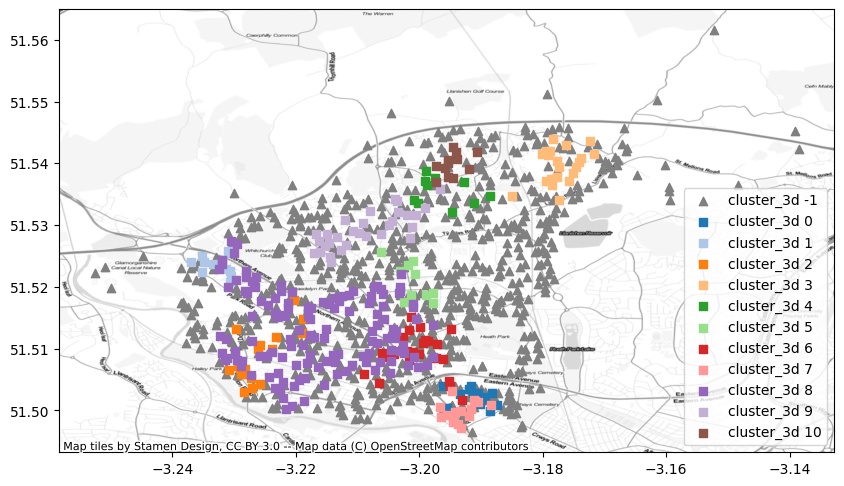

In [12]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels_3d) if c != -1])

# Scatter plot
for i in np.unique(df_hdbscan_3d['cluster_3d']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        marker = 's'
    idx = df_hdbscan_3d['cluster_3d'] == i
    ax.scatter(df_hdbscan_3d.loc[idx, 'long'], df_hdbscan_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_3d {i}", marker=marker)

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


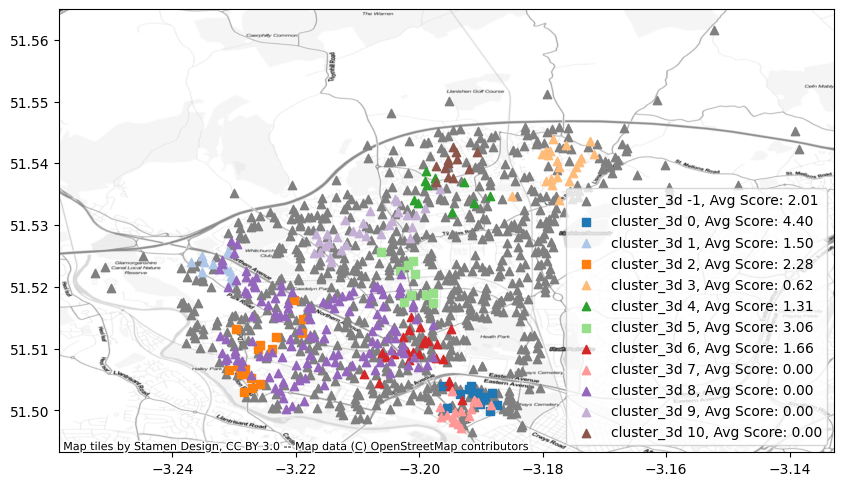

In [13]:

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels_3d) if c != -1])
# Group by cluster and calculate the mean score for each cluster
cluster_avg_scores = df_hdbscan_3d.groupby('cluster_3d')['Total_Score'].mean()

# Check if there are noise points
if -1 in cluster_avg_scores.index:
    noise_avg_score = cluster_avg_scores[-1]
else:
    noise_avg_score = None

# Scatter plot
for i in np.unique(df_hdbscan_3d['cluster_3d']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        # Use a square marker for clusters with an average score higher than the noise points
        marker = 's' if noise_avg_score and cluster_avg_scores[i] > noise_avg_score else '^'
    idx = df_hdbscan_3d['cluster_3d'] == i
    ax.scatter(df_hdbscan_3d.loc[idx, 'long'], df_hdbscan_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_3d {i}, Avg Score: {cluster_avg_scores[i]:.2f}", marker=marker)
    
    # Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


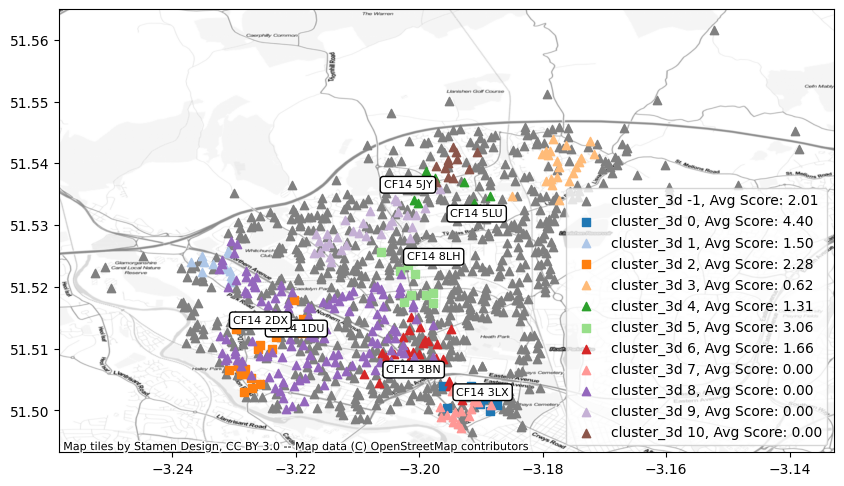

In [15]:
# Now, let's visualize the clustering results with different markers for noise points and clusters with average scores higher than the noise points
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot with different markers and new color map
for i in np.unique(df_hdbscan_3d['cluster_3d']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        # Use a square marker for clusters with an average score higher than the noise points
        marker = 's' if noise_avg_score and cluster_avg_scores[i] > noise_avg_score else '^'
    idx = df_hdbscan_3d['cluster_3d'] == i
    ax.scatter(df_hdbscan_3d.loc[idx, 'long'], df_hdbscan_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_3d {i}, Avg Score: {cluster_avg_scores[i]:.2f}", marker=marker)

# Annotate the postcodes with a score higher than 6
high_score_points = df_hdbscan_3d[df_hdbscan_3d['Total_Score'] > 5]
for _, row in high_score_points.iterrows():
    ax.annotate(row['RegAddress.PostCode'],
                (row['long'], row['lat']),
                textcoords="offset points", xytext=(-15,10), ha='center', fontsize=8, color='black', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
    
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


In [53]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

df_dbscan_3d = dynamic_scores_output.copy()

# Prepare the data with three dimensions: latitude, longitude, and SumScores
data_dbscan_3d = df_dbscan_3d[['lat', 'long', 'Total_Score']].values

# Standardize the data
scaler = StandardScaler()
data_dbscan_3d_scaled = scaler.fit_transform(data_dbscan_3d)

# Create the HDBSCAN model with the same parameters
dbscan_clusterer_3d = DBSCAN(min_samples=16)

# Fit the model with the three-dimensional standardized data
dbscan_clusterer_3d.fit(data_dbscan_3d_scaled)

# Get the labels
dbscan_labels_3d = dbscan_clusterer_3d.labels_

# Add the cluster labels to the dataframe
df_dbscan_3d['cluster_3d'] = dbscan_labels_3d

# Save or view the result
df_dbscan_3d.head()


,RegAddress.PostCode,lat,long,CompanyCount,Total_Score,color,size,label,cluster_3d
0,CF14 0AB,51.535540,-3.159611,1,0.0,gray,5,Not very suspicious,-1
1,CF14 0AD,51.545674,-3.166878,2,2.5,blue,10,Slightly suspicious,-1
2,CF14 0AF,51.536125,-3.159612,2,0.7,gray,5,Not very suspicious,-1
3,CF14 0AH,51.536829,-3.170213,2,0.9,gray,5,Not very suspicious,0
4,CF14 0AN,51.538160,-3.164782,1,0.0,gray,5,Not very suspicious,-1


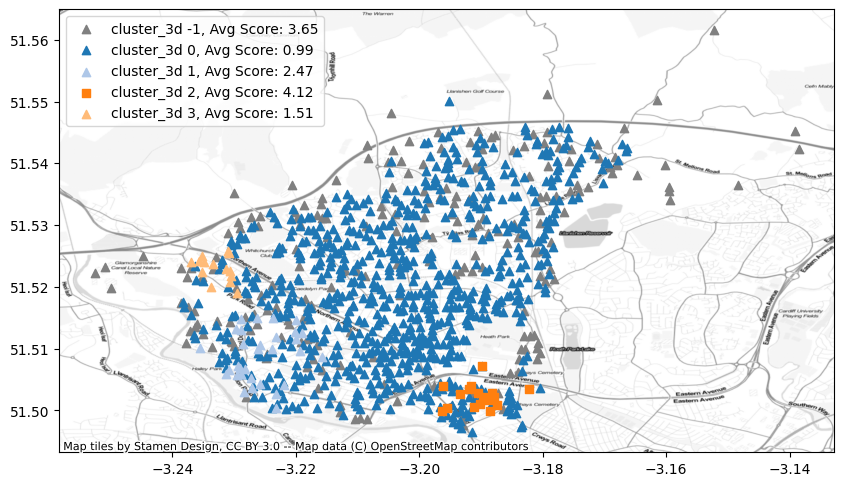

In [54]:

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(dbscan_labels_3d) if c != -1])
# Group by cluster and calculate the mean score for each cluster
cluster_avg_scores = df_dbscan_3d.groupby('cluster_3d')['Total_Score'].mean()

# Check if there are noise points
if -1 in cluster_avg_scores.index:
    noise_avg_score = cluster_avg_scores[-1]
else:
    noise_avg_score = None

# Scatter plot
for i in np.unique(df_dbscan_3d['cluster_3d']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        # Use a square marker for clusters with an average score higher than the noise points
        marker = 's' if noise_avg_score and cluster_avg_scores[i] > noise_avg_score else '^'
    idx = df_dbscan_3d['cluster_3d'] == i
    ax.scatter(df_dbscan_3d.loc[idx, 'long'], df_dbscan_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_3d {i}, Avg Score: {cluster_avg_scores[i]:.2f}", marker=marker)
    
    # Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


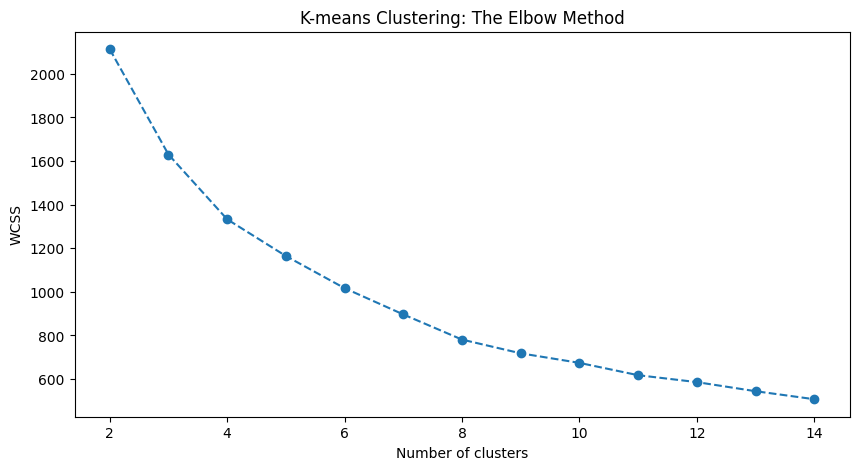

In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_kmeans_3d = dynamic_scores_output.copy()

# Prepare the data with three dimensions: latitude, longitude, and SumScores
data_kmeans_3d = df_kmeans_3d[['lat', 'long', 'Total_Score']].values

# Standardize the data
scaler = StandardScaler()
data_kmeans_3d_scaled = scaler.fit_transform(data_kmeans_3d)

# Use the Elbow method to find a good number of clusters using WCSS (Within-Cluster-Sum-of-Squares)
wcss = []

# Checking for up to 10 clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10, max_iter=300, algorithm='elkan')
    kmeans.fit(data_kmeans_3d_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(10,5))
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.title('K-means Clustering: The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [64]:
# Assuming 'n' is the optimal number of clusters after observing the plot
#n = int(input("Enter the optimal number of clusters (based on the Elbow plot): "))

kmeans = KMeans(n_clusters=9, init='k-means++', random_state=42,algorithm='elkan')
labels_kmeans = kmeans.fit_predict(data_kmeans_3d_scaled)

# Add the cluster labels to the dataframe
df_kmeans_3d['cluster_kmeans'] = labels_kmeans

# Save or view the result
df_kmeans_3d.head()

/Users/rainfow/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,RegAddress.PostCode,lat,long,CompanyCount,Total_Score,color,size,label,cluster_kmeans
0,CF14 0AB,51.535540,-3.159611,1,0.0,gray,5,Not very suspicious,4
1,CF14 0AD,51.545674,-3.166878,2,2.5,blue,10,Slightly suspicious,4
2,CF14 0AF,51.536125,-3.159612,2,0.7,gray,5,Not very suspicious,4
3,CF14 0AH,51.536829,-3.170213,2,0.9,gray,5,Not very suspicious,4
4,CF14 0AN,51.538160,-3.164782,1,0.0,gray,5,Not very suspicious,4


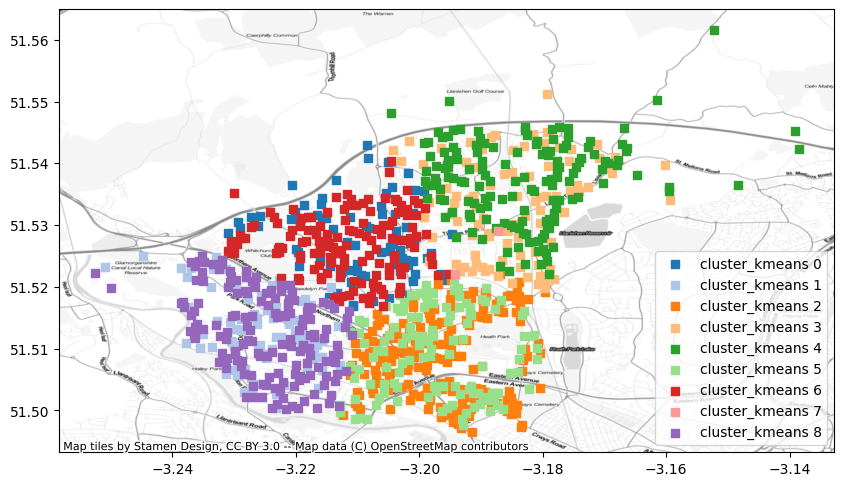

In [65]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels_kmeans) if c != -1])

# Scatter plot
for i in np.unique(df_kmeans_3d['cluster_kmeans']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        marker = 's'
    idx = df_kmeans_3d['cluster_kmeans'] == i
    ax.scatter(df_kmeans_3d.loc[idx, 'long'], df_kmeans_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_kmeans {i}", marker=marker)

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()
